In [1]:
!pip install xgboost

In [2]:
#Importing All the libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.model_selection import train_test_split
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:

df=pd.read_csv("Bengaluru_House_Data.csv")

In [4]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
df.shape

(13320, 9)

The Dataset has total 13320 rows and 9 column where price is target variable which is measure in Lakhs. Now lets check each features and work on it. First one is area_type

In [6]:
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

Sometimes in order to keep our model simple we have to make some assumptions. Hence we will drop some columns which we feel are not so important to predict the price.

In [7]:
df2=df.drop(["area_type","availability","balcony","society"], axis=1)
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [8]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

If we have very less amount of dataset then instead of just dropping these null values we can replace these with mean or median. Since our data set has 13300+ rows we are droppig these null values.

In [9]:
df3=df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

Next in Size column there like 3BHK and 4 bedroom so lets see what is happening with that column

In [10]:
df3["size"].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

So here bascically 4 bedroom mean same as 4 BHK. Hence lets create a column stating BHK which will have only the number of bedrooms or bhk number.

In [11]:

df3["bhk"]=df3["size"].apply(lambda x: int(x.split(" ")[0]))

In [12]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [13]:
df3["bhk"].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

Now this looks fine. But there are sum apartments which are 43BHK. So let's check those apprtments which are greater than 20 bhk.

In [14]:
df3[df3.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


Here we can see that there is a building which is 43bhk but total_sqft is just 2400 which is unreal and can be considered as outliers. Before going to this outliers lets check what is happening with total_sqft.

In [15]:
df3["total_sqft"].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

We observe that some of the value are in certain range and let's replace them with average value of 2 numbers.

In [16]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True
    

So here it will try to check whether the number is float or not. Lets see those values which are not float.

In [17]:
df3[~df3["total_sqft"].apply(is_float)]

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
...,...,...,...,...,...,...
12975,Whitefield,2 BHK,850 - 1060,2.0,38.190,2
12990,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000,3
13059,Harlur,2 BHK,1200 - 1470,2.0,72.760,2
13265,Hoodi,2 BHK,1133 - 1384,2.0,59.135,2


In [18]:
def avg_val(x):
  tokens=x.split('-')
  if len(tokens)==2:
    return(float(tokens[0])+float(tokens[1])/2)
  try:
    return float(x)
  except:
    return None
   

In [19]:
avg_val("2100 - 2850")

3525.0

In [20]:
df4=df3.copy()
df4["total_sqft"]=df4["total_sqft"].apply(avg_val)
df4.head(3)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3


# Feature Engineering

Let's find the price for per sqrt area. This will help us to some outlier cleaning in later stages.

In [21]:
df5=df4.copy()
df5["price_sqft"]=df5["price"]*100000/df5["total_sqft"]
df5.head()

,location,size,total_sqft,bath,price,bhk,price_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


Let's work on location column. Here it is categorical feature and if we have too many locations then it will be problem. Let's first check how many locations are there.

In [22]:
df5["location"].value_counts()

Whitefield                     534
Sarjapur  Road                 392
Electronic City                302
Kanakpura Road                 266
Thanisandra                    233
                              ... 
Ckikkakammana Halli              1
6th Block Rajaji Nagar           1
Kasthuri Nagar East Of NGEF      1
Ganga Nagar Extension            1
Bellandur,                       1
Name: location, Length: 1304, dtype: int64

In [23]:
len(df5["location"].unique())

1304

So there are total 1304 locations. Usually One Hot Encoding is done to convert this categorical data into numerical but this will have huge dimensions which will cause a problems. Hence we can use a concept of "OTHER" for those locations which will have very less number of counts.

In [24]:
df5["location"]=df5["location"].apply(lambda x: x.strip())# will remove the spaces before or after the names
location_stats=df5.groupby("location")["location"].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

So lets rename the count of those locations which has less than 10 data points as to "Other".

In [25]:
len(location_stats[location_stats<=10])

1052

In [26]:
locations_stats_less_than_10=location_stats[location_stats<=10]
locations_stats_less_than_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [27]:
df5["location"]=df.location.apply(lambda x: "Other" if x in locations_stats_less_than_10 else x)
len(df5["location"].unique())

283

# Outlier Detection  and Removal

In [28]:
df5.head()

,location,size,total_sqft,bath,price,bhk,price_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


Here lets check what is the minimum sqft per bedroom. Being data scintist if we ask our manager what is minimum sqft per bedroom and if manager says it can be approximately 300sqft then lets find those rows which has sqft /per bedroom is less than 300

In [29]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_sqft
9,Other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,Other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [30]:
df5.shape

(13246, 7)

So these rows of data can be removed as they dont make realistic sense

In [31]:
df6=df5[~(df5.total_sqft/df5.bhk<300)]

In [32]:
df6.shape

(12502, 7)

Now let's check price per sqft

In [33]:
df6.price_sqft.describe()

count     12456.000000
mean       6290.299983
std        4175.619211
min         267.829813
25%        4186.725844
50%        5281.690141
75%        6904.652015
max      176470.588235
Name: price_sqft, dtype: float64

So here we observe that min value is 267.82 which is not realistic one because no sites will have such lowest value and max value is also too high. These can be outliers. So lets make these as normal distribution and consider only those values which will lie between mean and std according to location because prices vary as per location.

In [34]:
def remove_price_outliers(df):
    df_out=pd.DataFrame()
    for key, val in df.groupby('location'):
        m=np.mean(val.price_sqft)
        std=np.std(val.price_sqft)
        reduced_df=val[(val.price_sqft>(m-std)) & (val.price_sqft<(m+std))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out


df7=remove_price_outliers(df6)
df7.shape

(10183, 7)

Next if we look at the dataset there are some data which has more price for 2 BHK as compared to 3 BHK for same location and also for same sqft area. Lets check those by plotting scatter plot.

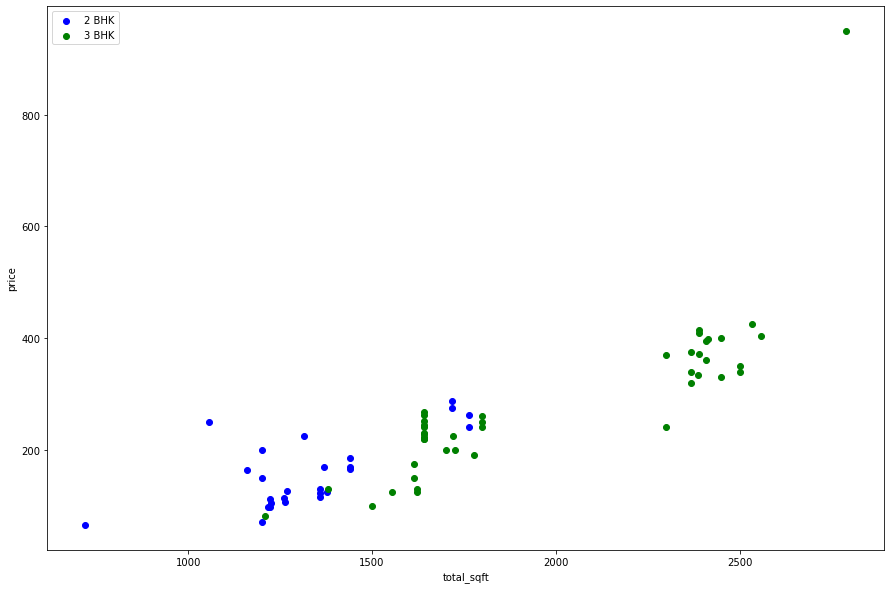

In [35]:
import matplotlib
def scatter_plot(df,location):
  bhk2=df[(df.location==location) & (df.bhk==2)]
  bhk3=df[(df.location==location) & (df.bhk==3)]
  matplotlib.rcParams['figure.figsize']=(15,10)
  plt.scatter(bhk2.total_sqft,bhk2.price, color="blue",label="2 BHK")
  plt.scatter(bhk3.total_sqft,bhk3.price, color="green",label="3 BHK")
  plt.xlabel("total_sqft")
  plt.ylabel("price")
  plt.legend()

scatter_plot(df6,"Rajaji Nagar")

So from above figure for same square foot area the price of 2 BHK is higher than price of 3 BHK. Lets observe for other locations.

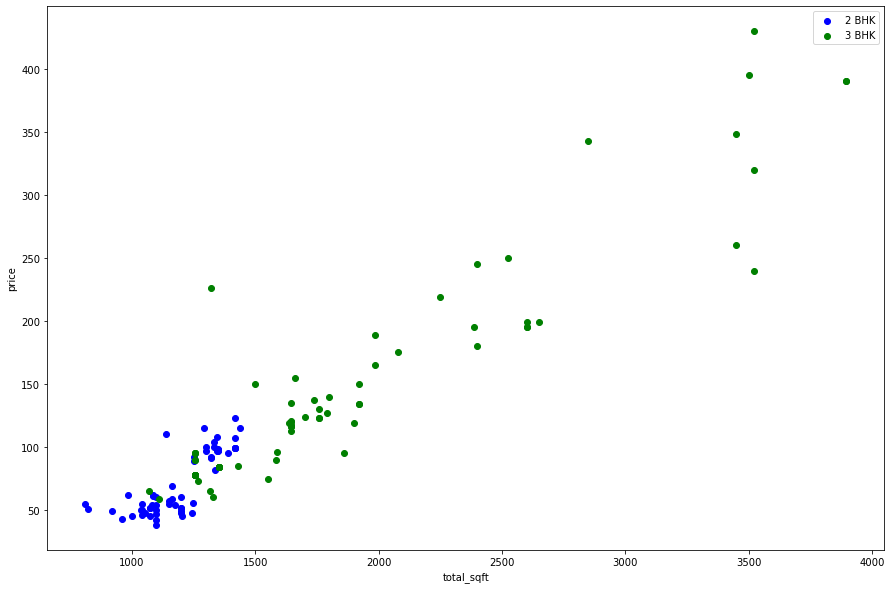

In [36]:

scatter_plot(df6,"Hebbal")

Lets remove these kind of outliers. After the below code the data set has those values which has price that is greater than the previous bhk site. For example

{

 '1': {

   'mean':4000,
   'std':2000,
    'count': 34
 },
 '2': {
   'mean':4300,
   'std':2300,
   'count': 22
 },
}

Here 1 and 2 are the bhk values, we will remove those 2 BHK appartments whose price_sqft is less than mean_price_sqft of 1 BHK appartments.

I am considering only cases where number of apartments (for given bhk) is greater than 5. Because less than that would be very few samples to run any logic. 5 is a randomly taken number.

In [37]:

def remove_bhk_outliers(df):
  exclude_indices=np.array([])
  for location, location_df in df.groupby('location'):
    bhk_stats={}
    for bhk,bhk_df in location_df.groupby('bhk'):
      bhk_stats[bhk]={
          'mean':np.mean(bhk_df.price_sqft),
          'std':np.std(bhk_df.price_sqft),
          'count':bhk_df.shape[0]
      }
    for bhk,bhk_df in location_df.groupby('bhk'):
      stats=bhk_stats.get(bhk-1)
      if stats and stats['count']>5:
        exclude_indices=np.append(exclude_indices,bhk_df[bhk_df.price_sqft<(stats['mean'])].index.values)
  return df.drop(exclude_indices,axis='index')

df8=remove_bhk_outliers(df7)
df8.shape

(7311, 7)

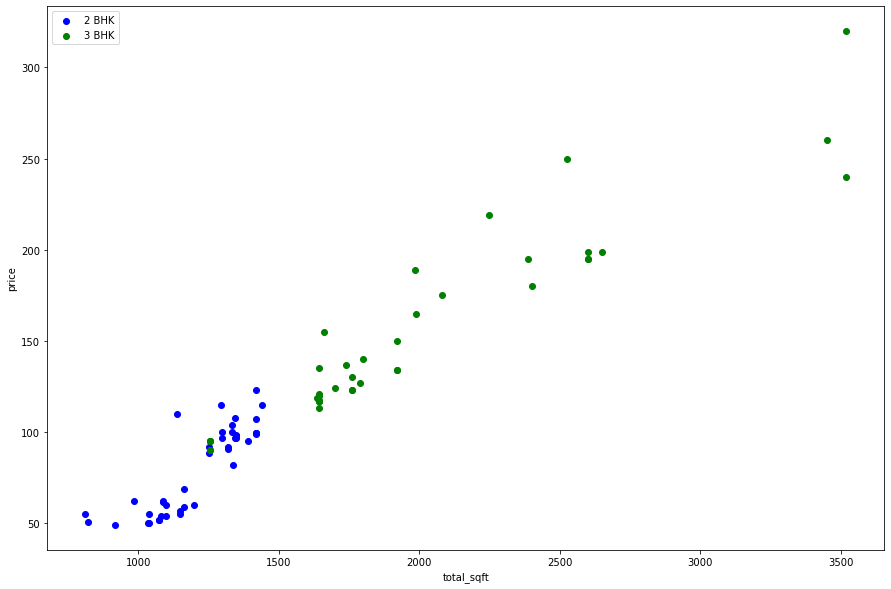

In [38]:
scatter_plot(df8,"Hebbal")

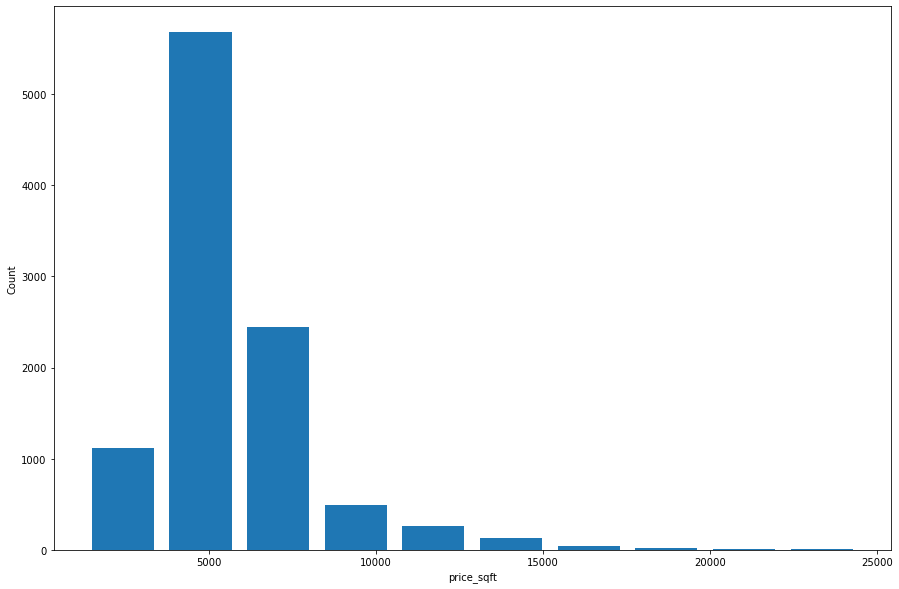

In [39]:
plt.hist(x=df7.price_sqft, rwidth=0.8)
plt.ylabel('Count')
plt.xlabel('price_sqft')
plt.show()

Here we can see that most of the sites price per sqft is 5000. Lets check with the appartemnts that have more baths.

In [40]:
df8.bath.unique()

array([ 3.,  2.,  1.,  4.,  5.,  8.,  6.,  7.,  9., 12., 16., 13.])

Usually A partment cannont have 16 bathrooms untill it is 14 or 15 BHK apartments. Lets check for those appartements which has greater than 10 bathrooms.

In [41]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_sqft
5282,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
5919,Other,10 BHK,12000.0,12.0,525.0,10,4375.000000
6005,Other,16 BHK,10000.0,16.0,550.0,16,5500.000000
6718,Other,11 BHK,6000.0,12.0,150.0,11,2500.000000
7040,Other,13 BHK,5425.0,13.0,275.0,13,5069.124424


There can be some un usual scenario here suppose we have 14 bath for 10 bhk house, so lets remove those apartment which has baths>bhk+2.

In [42]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_sqft
1644,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5243,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
5849,Other,6 BHK,11338.0,9.0,1000.0,6,8819.897689
8957,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330


In [43]:
df8.shape

(7311, 7)

In [44]:
df9=df8[df8.bath<df8.bhk+2]
df9

,location,size,total_sqft,bath,price,bhk,price_sqft
0,Devarabeesana Halli,3 BHK,1672.0,3.0,150.00,3,8971.291866
1,Devarabeesana Halli,3 BHK,1750.0,3.0,149.00,3,8514.285714
2,Devarabeesana Halli,3 BHK,1750.0,3.0,150.00,3,8571.428571
4,Devarachikkanahalli,2 BHK,1250.0,2.0,40.00,2,3200.000000
5,Devarachikkanahalli,2 Bedroom,1200.0,2.0,83.00,2,6916.666667
...,...,...,...,...,...,...,...
10173,Yeshwanthpur,3 BHK,1692.0,3.0,108.00,3,6382.978723
10175,Yeshwanthpur,6 Bedroom,2500.0,5.0,185.00,6,7400.000000
10177,Yeshwanthpur,2 BHK,1160.0,2.0,64.08,2,5524.137931
10180,Yeshwanthpur,3 BHK,1855.0,3.0,135.00,3,7277.628032


So Now the dataset quite clean and outliers has been removed as well. Lets now drop 2 features that is size and price_sqft which were created to check the outliers and there are other feature which represent same information.

In [45]:
df9.drop(["size","price_sqft"], inplace=True, axis=1)

In [46]:
df9

,location,total_sqft,bath,price,bhk
0,Devarabeesana Halli,1672.0,3.0,150.00,3
1,Devarabeesana Halli,1750.0,3.0,149.00,3
2,Devarabeesana Halli,1750.0,3.0,150.00,3
4,Devarachikkanahalli,1250.0,2.0,40.00,2
5,Devarachikkanahalli,1200.0,2.0,83.00,2
...,...,...,...,...,...
10173,Yeshwanthpur,1692.0,3.0,108.00,3
10175,Yeshwanthpur,2500.0,5.0,185.00,6
10177,Yeshwanthpur,1160.0,2.0,64.08,2
10180,Yeshwanthpur,1855.0,3.0,135.00,3


Before going to Modelling part, there is one feature which is categorical, so lets convert it to numerical by usinh One Hot Encoding.

In [47]:
dummies=pd.get_dummies(df9.location)
dummies.head(10)

,Devarabeesana Halli,Devarachikkanahalli,Mysore Highway,Rachenahalli,Thanisandra,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df10=pd.concat([df9,dummies.drop(["Other"],axis=1)], axis=1)
df10.head()

,location,total_sqft,bath,price,bhk,Devarabeesana Halli,Devarachikkanahalli,Mysore Highway,Rachenahalli,Thanisandra,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,Devarabeesana Halli,1672.0,3.0,150.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Devarabeesana Halli,1750.0,3.0,149.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Devarabeesana Halli,1750.0,3.0,150.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Devarachikkanahalli,1250.0,2.0,40.0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Devarachikkanahalli,1200.0,2.0,83.0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df10=df10.drop(["location"],axis=1)

In [50]:
df10.head()

,total_sqft,bath,price,bhk,Devarabeesana Halli,Devarachikkanahalli,Mysore Highway,Rachenahalli,Thanisandra,1st Block Jayanagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1672.0,3.0,150.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1750.0,3.0,149.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1750.0,3.0,150.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1250.0,2.0,40.0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1200.0,2.0,83.0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
X=df10.drop(["price"],axis=1)
Y=df10.price

In [52]:
X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.20,random_state=10)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(5789, 254) (5789,)
(1448, 254) (1448,)


In [53]:
lnr_reg = LinearRegression()
lnr_reg.fit(X_train,y_train)
print("train score",lnr_reg.score(X_train,y_train))
print("test score",lnr_reg.score(X_test,y_test))

train score 0.8466444754845951
test score 0.8651357041700027


In [54]:
DTREG = DecisionTreeRegressor()
DTREG.fit(X_train,y_train)
print("train score",DTREG.score(X_train,y_train))
print("test score",DTREG.score(X_test,y_test))

train score 0.9921321003905342
test score 0.8118800274009993


In [55]:
rand_for = RandomForestRegressor()
rand_for.fit(X_train,y_train)
print("train score",rand_for.score(X_train,y_train))
print("test score",rand_for.score(X_test,y_test))

train score 0.9579592990475323
test score 0.8380250145564376


In [56]:
XGBReg   = XGBRegressor  ()
XGBReg.fit(X_train,y_train)
print("train score",XGBReg.score(X_train,y_train))
print("test score",XGBReg.score(X_test,y_test))

train score 0.9383346584663236
test score 0.8848238176263947


If we observe the result of all the models the result is quite good but model is overfitting in all excpet the Linear Regression. Hence we can say the Linear Regression can be best suitable model for this dataset.

In [57]:
def predict_price(location, sqft,bath,bhk):
    loc_index=np.where(X.columns==location)[0][0]
    print(loc_index)
    x=np.zeros(len(X.columns))
    print(len(x))
    x[0]=sqft
    x[1]=bath
    x[2]=bhk
    if loc_index>=0:
        x[loc_index]=1
    return lnr_reg.predict([x])[0]
    
    

In [58]:
X.columns

Index(['total_sqft', 'bath', 'bhk', ' Devarabeesana Halli',
       ' Devarachikkanahalli', ' Mysore Highway', ' Rachenahalli',
       ' Thanisandra', '1st Block Jayanagar', '1st Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=254)

In [59]:
predict_price('1st Phase JP Nagar',1000,3,3)

9
254


85.09460327313022

In [60]:
predict_price('Vishveshwarya Layout',1000,3,3)

245
254


15.26788146587134

So the predicted price is in Lakhs.